

For this MIFE scheme, we used ElGamal as the public-key encryption scheme

This notebook was runned with a HP Laptop 14s-dq1xxx with a 1GHz Intel Core i5 and 8GB RAM running Windows 10, 64 bit and Python 3.10 using `PyCryptoDome` and `numpy`

# Parameter generation

We first begin by generating some 1024 bit $G, P$ parameters that will be recycled for the whole experiment, since it is the most time consuming operation.

We also have to take into account that for every MIFE instance, a single $r$ randomizer value is used for all ElGamal keys


In [1]:
from utils import get_GP

G, P = get_GP(load_file = True, nbits = 1024)

# Tree Demonstration

After this we proceed to show an initial representation of the tree, and the following operations

1. **Tree generation and population**: The tree nodes are initialized depending on the $N$ value and a dataset is added
2. **Noise addition**: Noise is added to each node
3. **Encryption**: Each node is encypted. Note that the result of *ElGamal* encryption gives two large values of which only the first two digits are represented in the tree

In this case we will use a tree of size $N=3$(8 leaves and 15 nodes) and a random population of 100 values

Num_leaves: 8, Num_nodes: 15


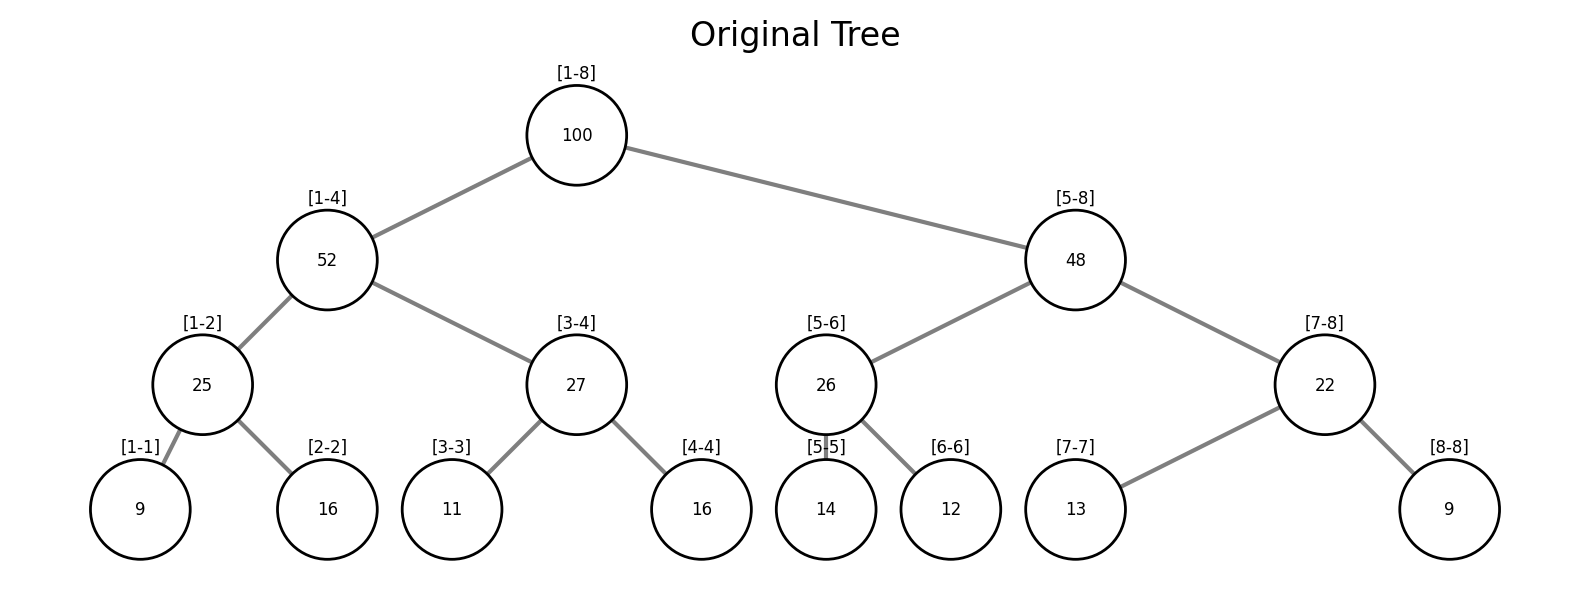

Query [5, 7]: 39


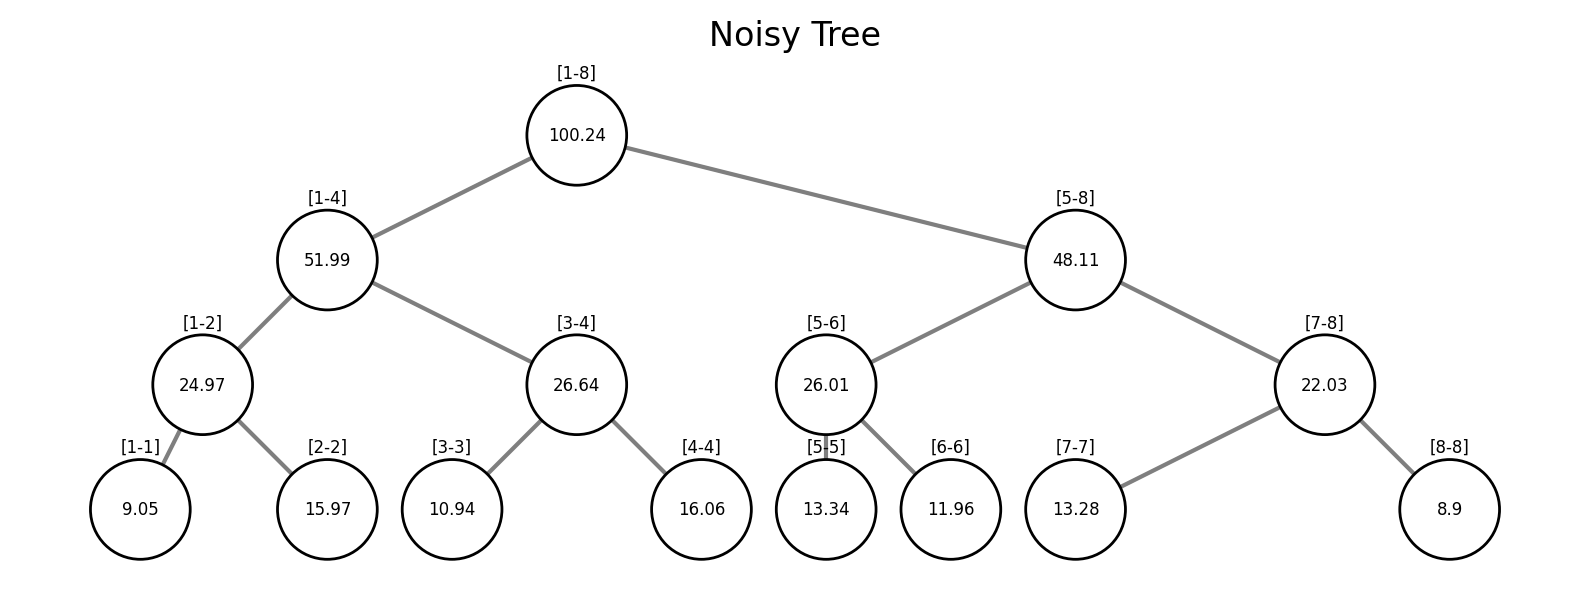

Query [5, 7]: 39.291295216754634


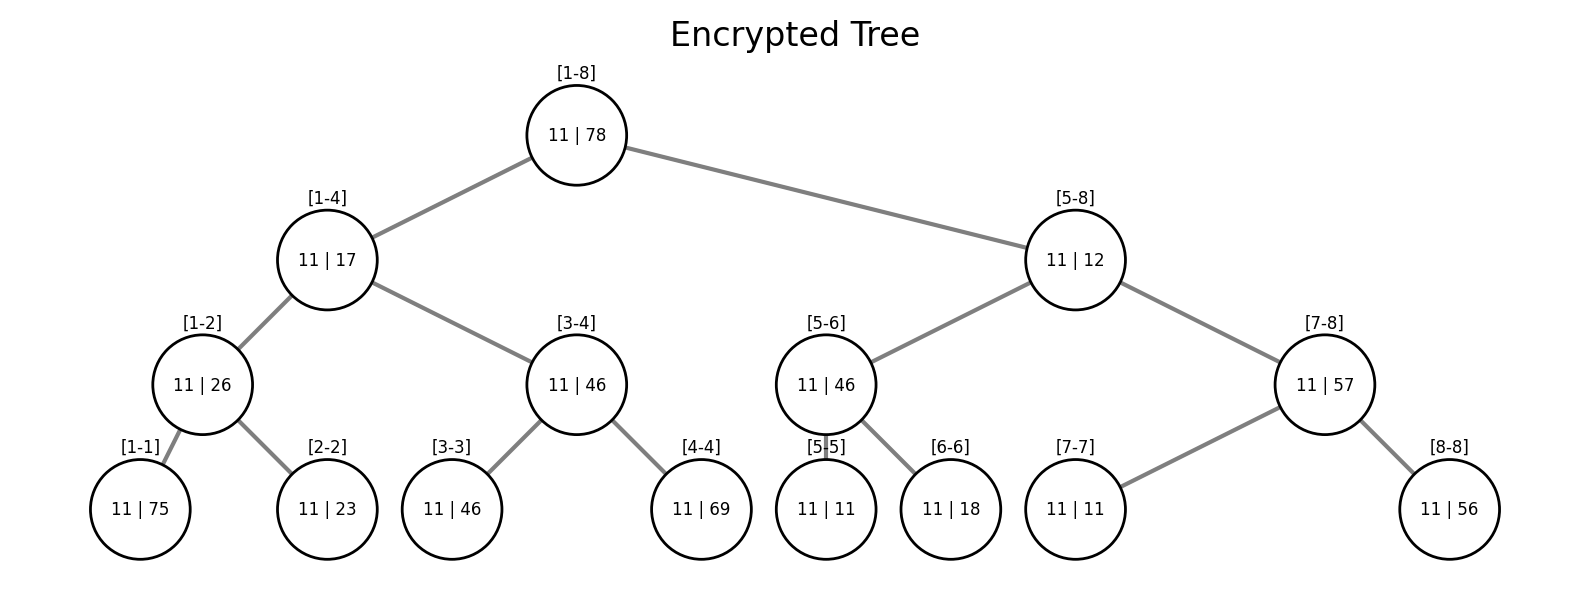

Query [5, 7]: 39
Query [5, 7]: 39
{'generateAndPopulate': 0.0008159999997587875, 'generateKeys': 0.4994368553161621, 'addNoise': 8.759999764151871e-05, 'encrypt': 0.2044370174407959}


In [3]:
import random
import numpy as np
from utils import *
from entities import Curator
from elGamal import ElGamal
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dpi_0 = plt.rcParams['figure.dpi']
plt.rcParams['figure.dpi'] = 200


N = 3
DATASET_SIZE = 100

print(f"Num_leaves: {2**N}, Num_nodes: {2**(N+1)-1}")

x = np.random.randint(1, 2**N+1, DATASET_SIZE)
C = Curator(N, x, G=G, P=P)
query = random.randint(1, 2**N-1)
query = [query, random.randint(query+1, 2**N)]
plot_tree(C.T, "Original Tree", fontsize=6)
print(f"Query {query}: {C.read(query)}")
C.add_noise(10)
plot_tree(C.T, "Noisy Tree", fontsize=6)
print(f"Query {query}: {C.read(query)}")
C.encrypt()
plot_tree(C.T, "Encrypted Tree", fontsize=6)
print(f"Query {query}: {C.read(query)}")
print(f"Query {query}: {C.read(query, f_key=True)}")
print(C.times)
# print(C.mife.dec_l1(C.T.get_values()))

*In the previous representation, for practical reasons we only show the last two digits of the encrypted nodes*

# Experimental Evaluation

We will now proceed to conduct a series of experiments, by varying the different scheme settings.

We will use every combination of $n=5, 6, 7, 8, 9, 10$(resulting in binary trees of sizes 63, 127, 255, 511, 1023 and
2047 respectively.) and datasizes of $100, 500, 1000, 10000$

For each experiment we will capture the times for:
- Laplacian Noise
- Key Generation
- Encryption
- Tree Generation
- Total Setup Time

In [4]:
N_values = range(5, 11)
Dataset_Sizes = [100, 500, 1000, 10000]


df1 = pd.DataFrame(columns=['Dataset Size', 'Number of Leaves', 'Time (ms)'])
df2 = pd.DataFrame(columns=['Total Number of Tree Nodes', 'Laplacian Noise', 'Key Generation', 'Encryption', 'Tree Generation(Dataset size = 10000)', 'Total Time'])

for dataset_size in Dataset_Sizes:
    for N in N_values:
        x = np.random.randint(1, 2**N, dataset_size)
        C = Curator(N, x, G=G, P=P)
        C.add_noise(10)
        C.encrypt()
        df1 = pd.concat([df1, pd.DataFrame({'Dataset Size': [dataset_size], 'Number of Leaves': [2**N], 'Time (ms)': [C.times["generateAndPopulate"]*1000]})], ignore_index=True)
        if dataset_size == 10000:
            df2 = pd.concat([df2, pd.DataFrame({'Total Number of Tree Nodes': [2**(N+1)-1], 'Laplacian Noise': [C.times["addNoise"]], 'Key Generation': [C.times["generateKeys"]], 'Encryption': [C.times["encrypt"]],'Tree Generation(Dataset size = 10000)': [C.times["generateAndPopulate"]], 'Total Time': [sum(C.times.values())]})], ignore_index=True)
        # print(N, dataset_size, C.times)

# save to excel
# df1.to_excel("cw2_1.xlsx")
# df2.to_excel("cw2_2.xlsx")

In [5]:
df1

,Dataset Size,Number of Leaves,Time (ms)
0,100,32,0.8824
1,100,64,2.6801
2,100,128,1.0335
3,100,256,2.2857
4,100,512,1.3155
5,100,1024,95.1316
6,500,32,1.4093
7,500,64,1.7126
8,500,128,2.3894
9,500,256,3.6858


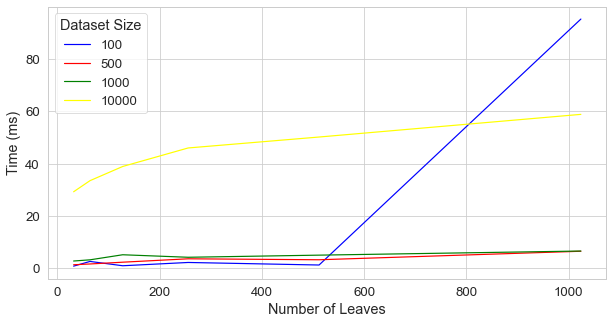

In [6]:
plt.rcParams['figure.dpi'] = dpi_0


sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(10, 5))
colors = ["blue", "red", "green", "yellow"]
ax = sns.lineplot(x="Number of Leaves", y="Time (ms)", hue="Dataset Size", data=df1, palette=colors)

In [7]:
df2

,Total Number of Tree Nodes,Laplacian Noise,Key Generation,Encryption,Tree Generation(Dataset size = 10000),Total Time
0,63,0.000159,1.299192,0.684218,0.029252,2.012822
1,127,0.000379,2.589227,1.341661,0.033487,3.964754
2,255,0.000449,5.114492,2.699409,0.038898,7.853249
3,511,0.000836,10.330198,5.231584,0.045962,15.608580
4,1023,0.001717,21.151889,10.531241,0.050135,31.734981
5,2047,0.006985,76.440659,48.788246,0.058780,125.294669


# Key Generation

Finally we capture a, fully unrealistic/worst-case scenario, retrieve the values from all the leaves of a 1024 leaves tree

In [8]:
N = 10

x = np.random.randint(1, 2**N, 10000)
C = Curator(N, x, G=G, P=P)
interval = (10, 16)
interval = (interval, C.read(interval))
C.encrypt()

In [9]:
t0 = time.perf_counter()
checksum = sum([C.T.query_interval([i, i]) for i in range(1, 2**N+1)])

if checksum == 10000:
    print("Time to retrieve all leaves: ", round(1000*(time.perf_counter() - t0), 3), "ms", sep="")
else:
    print("Error", time.time() - t0)
t0 = time.perf_counter()

print(f"Query {interval[0]}: {interval[1]}")
t0 = time.perf_counter()
checksum = C.read(interval[0])
print(f"Time to retrieve interval: {round(1000*(time.perf_counter() - t0), 2)}ms, Query: {checksum}")
t0 = time.perf_counter()
checksum = C.read((interval[0]), f_key=True)
print(f"Time to retrieve interval with functional key: {round(1000*(time.perf_counter() - t0), 2)}ms, Query: {checksum}")

from entities import generate_f_key

f_key = generate_f_key(C.mife.msk, P)
print(f"Time to generate functional key for 1024 secret keys: {round(1000*(time.perf_counter() - t0), 2)}ms")

# generating one key
t0 = time.perf_counter()
_ = ElGamal(G=G, P=P, r=1)
print(f"Time to generate one key: {round(1000*(time.perf_counter() - t0), 2)}ms")



Time to retrieve all leaves: 404.108ms
Query (10, 16): 80
Time to retrieve interval: 3.43ms, Query: 80
Time to retrieve interval with functional key: 9.15ms, Query: 80
Time to generate functional key for 1024 secret keys: 13.87ms
Time to generate one key: 36.8ms
